# Simple molecular dynamics simulatin by Julia
Author: Shinji Iida

In this book, I show a code for molecular dynamics simulation of one-particle harmonic system.
In the simulation, I use velocity verlet algorithm.

## Aim
- To look at energy conservation 
- To see the trajectory of the harmonic oscillator.

## Harmonic oscillator 

In [ ]:
using Plots
using Random

module harmonic_mod

    struct system
        mass::Float64
        spring_const::Float64
        x_eq::Float64
    end

    function potential(x, x_eq, k = 1.0)
        potential = 0.5 * k * (x - x_eq)^2
        force     = - k * (x - x_eq) 
        return potential
    end

    function force(x, x_eq, k = 1.0)
        force = - k * (x - x_eq) 
        return force
    end 

end

module lj_mod
    function lj(r, ϵ, σ)
        potential = 4ϵ * ((σ/r)^12 - (σ/r)^6)
        force     = -24ϵ * (2*(σ/r)^12 - (σ/r)^6) * r^-1
        return force, potential    
    end
end 

function kinetic_energy(v, mass)
    return 0.5 * mass * v^2
end

function gaussian(mu = 0.0, sigma = 1.0)
    #Box–Muller transform is implemented. 
    #But, instead, we can use randn() function in julia.
    rng = MersenneTwister()
    u1 = rand(rng)
    u2 = rand(rng)
    z1 = sigma * sqrt(-2.0 * log(u1)) * cos(2 * pi * u2) + mu
    z2 = sigma * sqrt(-2.0 * log(u1)) * sin(2 * pi * u2) + mu
    return z1, z2
end

function velocityVerlet(x0, dt, n_steps, sys)
    #=
    Args:
        x0: initial cooridnates
        dt: time step
        n_stemps: the number of steps 
        sys: system definition (constructor)
    Return:
        nothing
    =#  
    
    # ---  
    spring_const = sys.spring_const
    mass = sys.mass 
    x_eq = sys.x_eq 
    
    # --- Initialization ---
    x_t  = x0
    v_t = 1.0 #gaussian()
    v_t = v_t[1]
    PE = harmonic_mod.potential(x_t, x_eq, spring_const)
    f_t= harmonic_mod.force(x_t, x_eq, spring_const) 
    KE = kinetic_energy(v_t, mass)
    H = PE + KE
    a_t = f_t / mass
 
    # --- main loop ---
    fout = open("traj.dat", "w");
    write(fout, "$x_t $v_t $PE $KE $H \n")
    for i in 1:n_steps
        v_half = v_t + 0.5 * a_t * dt
        x_t = x_t + v_half * dt
        PE = harmonic_mod.potential(x_t, x_eq, spring_const) 
        f_t= harmonic_mod.force(x_t, x_eq, spring_const) 
        a_t = f_t / mass
        v_t = v_half + 0.5 * a_t * dt
        KE  = kinetic_energy(v_t, mass)
        H = PE + KE
        write(fout, "$x_t $v_t $PE $KE $H \n")
    end
    close(fout)
    return nothing
end

function plot_box_muller()
    v1 = []
    v2 = []
    for i in 1:10^5
        (z1, z2) = box_muller()        
        push!(v1, z1)
        push!(v2, z2)
    end
    histogram([v1,v2], bins=100, fill=0.5, markerstrokewidth=0.0) #two col means two data frames
end

function get_traj(filename)
    fin = open(filename, "r")
    xs = []
    vs = []
    for line in eachline(fin)
        x, v, pe, ke, h = split(line)
        push!(xs,parse(Float64, x))
        push!(vs,parse(Float64, v))
    end
    return xs, vs
end

function draw_energy(filename)
    fin = open(filename, "r")
    ps = []
    ks = []
    hs = []
    for line in eachline(fin)
        x, v, pe, ke, h = split(line)
        push!(ps,parse(Float64, pe))
        push!(ks,parse(Float64, ke))
        push!(hs,parse(Float64, h))
    end
    plot(1:length(ps),[ps,ks,hs], label=["Potential" "Kinetic" "Hamiltonian"]) #label: do not add comma!
end

In [139]:
x0 = 0.0
dt = 0.1 #0.99995
n_steps = 10^2
sys = harmonic_mod.system(1.0, 1.0, 0.0)

Main.harmonic_mod.system(1.0, 1.0, 0.0)

In [140]:
@time velocityVerlet(x0, dt, n_steps, sys)

  0.000898 seconds (1.83 k allocations: 246.891 KiB)


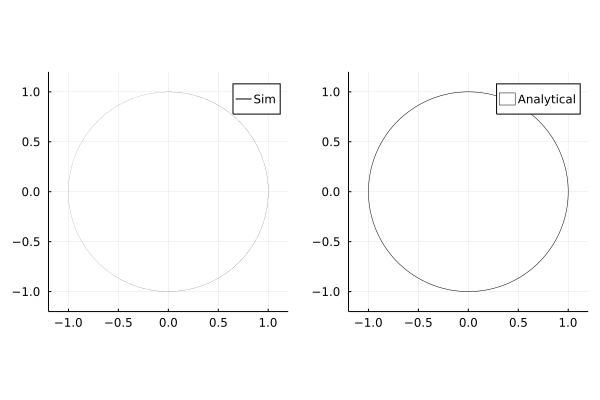

In [141]:
function circuleShape(h, k, r)
    # (r*sinθ)^2 + (r*cosθ)^2 
    θ = LinRange(0, 2π, 500)
    h .+ r*sin.(θ), k .+r*cos.(θ)
end
xs, vs = get_traj("traj.dat")

xlims = (-1.2,1.2)
ylims = (-1.2,1.2)
p1 = plot((xs, vs), xlims = xlims, ylims = ylims, c = :red, lw = 0.1, 
    linecolor = :black, label = "Sim", fillalpha = 0.2, aspect_ratio = 1)
p2 = plot(circuleShape(0,0,1),seriestype = [:shape], 
    xlims = xlims, ylims = ylims,c = :red, lw = 0.5, 
    linecolor = :black, label = "Analytical", fillalpha = 0.0, aspect_ratio = 1)
plot(p1, p2)

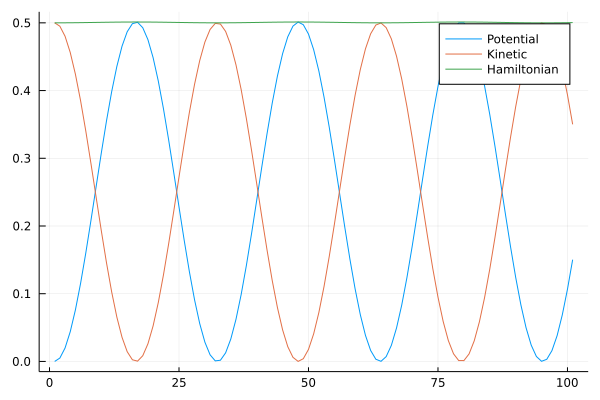

In [142]:
draw_energy("traj.dat")